<a href="https://colab.research.google.com/github/enakai00/colab_rlbook/blob/master/Chapter01/Bandit_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[BA-01]**

Import modules.

In [0]:
import numpy as np
from pandas import DataFrame
import matplotlib
matplotlib.rcParams['font.size'] = 12

**[BA-02]**

Define the Bandit class.

In [0]:
class Bandit:
  def __init__(self, arms=10):
    self.arms = arms
    self.means = np.random.normal(loc=0.0, scale=1.0, size=self.arms)

  def select(self, arm):
    reward = np.random.normal(loc=self.means[arm], scale=1.0)
    return reward
  
  def disturb(self):
    self.means += np.random.normal(loc=0.0, scale=0.05, size=self.arms)

**[BA-03]**

Define a funtion to collect samples to estimate the means.

In [0]:
def estimate_means(bandit, steps):
  rewards = {}
  for arm in range(bandit.arms):
    rewards[arm] = []

  for _ in range(steps):
    arm = np.random.randint(bandit.arms)
    reward = bandit.select(arm)
    rewards[arm].append(reward)

  averages = []
  for arm in range(bandit.arms):
    averages.append(sum(rewards[arm]) / len(rewards[arm]))

  return averages

**[BA-04]**

Execute estimation and show the result.

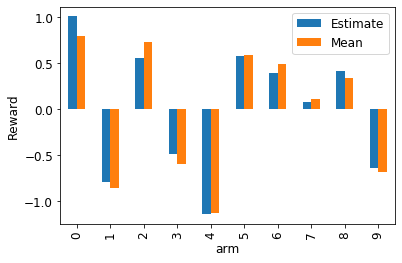

In [4]:
bandit = Bandit()
estimates = estimate_means(bandit, steps=1000)

ax = DataFrame({'Estimate': estimates, 'Mean': bandit.means}).plot(kind='bar')
_ = ax.set_xlabel('arm')
_ = ax.set_ylabel('Reward')

**[BA-05]**

Define a function to run an episode.

In [0]:
def get_action(qs, epsilon):
  if np.random.random() < epsilon:
    # Explore: choose randomly.
    return np.random.randint(len(qs))
  else:
    # Exploit: choose the arm with the max average.
    return np.argmax(qs)
      
def episode(bandit, epsilon, steps):
  total_rewards = [0]
  qs = np.zeros(bandit.arms)
  count = np.zeros(bandit.arms)
  
  for _ in range(steps):
    arm = get_action(qs, epsilon)
    reward = bandit.select(arm)
    # Append total rewards
    total_rewards.append(total_rewards[-1] + reward)

    # Update an average of rewards.
    count[arm] += 1
    qs[arm] += (reward - qs[arm]) / count[arm]

  return total_rewards

**[BA-06]**

Run episodes with various epsilons.

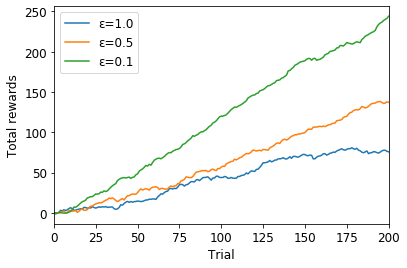

In [6]:
bandit = Bandit()
rewards = {}
for epsilon in [1.0, 0.5, 0.1]:
  rewards['ε={}'.format(epsilon)] = episode(bandit, epsilon, steps=200)

ax = DataFrame(rewards).plot()
_ = ax.set_xlabel('Trial')
_ = ax.set_ylabel('Total rewards')

**[BA-07]**

Define a function to run an episode for a nonstationary problem.

In [0]:
def episode_nonstationary(bandit, alpha, steps, epsilon=0.1, disturb=False):
  total_rewards = [0]
  qs = np.zeros(bandit.arms)
  count = np.zeros(bandit.arms)
  
  for _ in range(steps):
    arm = get_action(qs, epsilon)
    reward = bandit.select(arm)
    # Append total rewards
    total_rewards.append(total_rewards[-1] + reward)

    if disturb: # Disturb means
      bandit.disturb()

    if alpha == 0: # Use an average for an estimation of means.
      count[arm] += 1
      qs[arm] += (reward - qs[arm]) / count[arm]
    else: # Use a constant step size.
      qs[arm] += alpha * (reward - qs[arm])
    
  return total_rewards

**[BA-08]**

Run episodes with various step sizes for a stationary problem. (α=0 for an average estimation.) 

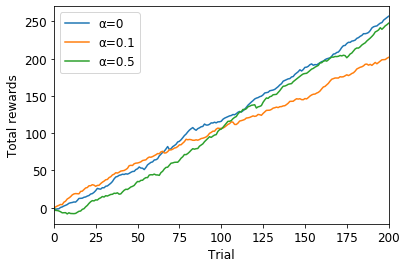

In [55]:
bandit = Bandit()
rewards = {}
for alpha in [0, 0.1, 0.5]:
  rewards['α={}'.format(alpha)] = \
      episode_nonstationary(bandit, alpha, steps=200)

ax = DataFrame(rewards).plot()
_ = ax.set_xlabel('Trial')
_ = ax.set_ylabel('Total rewards')

**[BA-09]**

Run episodes with various step sizes for a nonstationary problem. (α=0 for an average estimation.) 

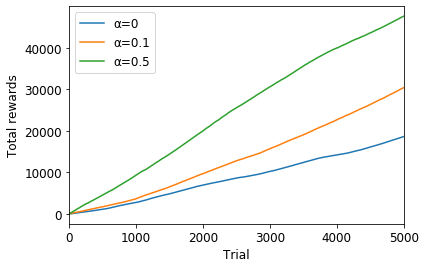

In [34]:
bandit = Bandit()
rewards = {}
for alpha in [0, 0.1, 0.5]:
  rewards[u'α={}'.format(alpha)] = \
      episode_nonstationary(bandit, alpha, steps=5000, disturb=True)

ax = DataFrame(rewards).plot()
_ = ax.set_xlabel('Trial')
_ = ax.set_ylabel('Total rewards')

**[BA-10]**

Define a function to run an episode with optimistic inital values.

In [0]:
def episode_optimistic_init(bandit, epsilon, q_init, steps):
  rewards = [0]
  qs = np.ones(bandit.arms) * q_init
  
  for _ in range(steps):
    arm = get_action(qs, epsilon)
    reward = bandit.select(arm)
    rewards.append(rewards[-1] + reward)
    qs[arm] += 0.5 * (reward - qs[arm])
 
  return rewards

**[BA-11]**

Run episodes with realistic and optimistic inital values.

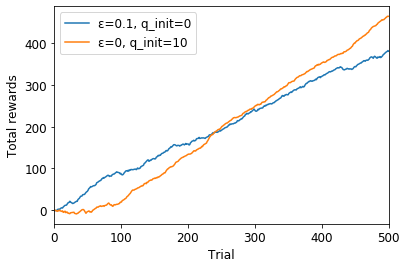

In [41]:
bandit = Bandit()
rewards = {}
rewards['ε={}, q_init={}'.format(0.1, 0)] =\
     np.array(episode_optimistic_init(bandit, epsilon=0.1, q_init=0, steps=500))
rewards['ε={}, q_init={}'.format(0, 10)] =\
     np.array(episode_optimistic_init(bandit, epsilon=0, q_init=10, steps=500))

ax = DataFrame(rewards).plot()
_ = ax.set_xlabel('Trial')
_ = ax.set_ylabel('Total rewards')